In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# general articles on feature selection
https://scikit-learn.org/stable/modules/feature_selection.html   
https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2

# The Ultimate Guide to 12 Dimensionality Reduction Techniques
# part 1: big mart sales data
https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets
from sklearn.feature_selection import f_regression

# read big mart sales data
column `Item_Outlet_Sales` is dependent variable   
columns `Item_Identifier` and `Outlet_Identifer` are unique IDs

In [4]:
# read the data
train=pd.read_csv("big_mart_sales_train.csv")

In [5]:
train.shape
train.columns
train.info()
train.head()

(8523, 12)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### get values counts of categorical variables

In [6]:
categorical_var = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
for var in categorical_var:
    print('categorical variable:', var)
    train[var].value_counts()

categorical variable: Item_Fat_Content


Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

categorical variable: Item_Type


Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

categorical variable: Outlet_Size


Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

categorical variable: Outlet_Location_Type


Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

categorical variable: Outlet_Type


Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

# 3.1 Missing Value Ratio

In [7]:
# checking the percentage of missing values in each variable
train.isnull().sum()/len(train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [8]:
# variable names with less than 20% missing values
a = train.isnull().sum()/len(train)*100
# saving column names in a variable
variables = train.columns
variable = [ ]
for i in range(0,12):
    if a[i]<=20:   #setting the threshold as 20%
        variable.append(variables[i])

variable

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

# 3.2 Low Variance Filter

In [9]:
temp = train['Outlet_Size'].mode()
type(temp)
temp

pandas.core.series.Series

0    Medium
dtype: object

In [10]:
# impute missing values
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True)
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)

In [11]:
# check for missing values
train.isnull().sum()/len(train)*100

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

In [12]:
# calculate variance
train.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

In [13]:
# consider independent variables that are numeric
# variable names with > 10% variance
numeric = train[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']]
var = numeric.var()
numeric = numeric.columns
variable = [ ]
for i in range(0,len(var)):
    if var[i]>=10:   #setting the threshold as 10%
        variable.append(numeric[i])

variable

['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year']

# 3.3 High Correlation Filter
### result
- no highly correlated independent variables   
- if correlation 0.5 - 0.6, should consider dropping 1 of variables

In [14]:
# get correlation between independent variables that are numeric
df=train.drop('Item_Outlet_Sales', 1)
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
Item_Weight,1.000000,-0.014168,0.024951,0.007739
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834
Item_MRP,0.024951,-0.001315,1.000000,0.005020
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000


# 3.4 Random Forest

### drop the ID variables

In [15]:
df=df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,Medium,Tier 3,Grocery Store
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1


### one-hot encode categorical variables

In [16]:
df=pd.get_dummies(df)

In [17]:
df.columns
df.head()

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,1999,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,2009,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,1999,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,1998,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,1987,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


### fit random forest model

In [18]:
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(df,train.Item_Outlet_Sales)

RandomForestRegressor(max_depth=10, random_state=1)

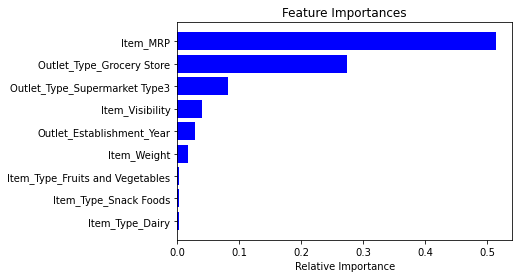

In [19]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
_ = plt.title('Feature Importances')
_ = plt.barh(range(len(indices)), importances[indices], color='b', align='center')
_ = plt.yticks(range(len(indices)), [features[i] for i in indices])
_ = plt.xlabel('Relative Importance')
_ = plt.show()

### could manually select features based on above plot
### next cell will use `sklearn` method to make selection using default criteria
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel   
https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel

In [20]:
feature_select = SelectFromModel(model, prefit=True)
df_new = feature_select.transform(df)

In [21]:
df.shape
df_new.shape

(8523, 35)

(8523, 5)

In [24]:
# mask for features selected
feature_select.get_support()

array([False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True])

In [23]:
df.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object

In [25]:
df.columns[feature_select.get_support()]

Index(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

# 3.5 Backward Feature Elimination (ie Recursive Feature Elimination)
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html   
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html   
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html   
https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [30]:
# create regression objext
lreg = LinearRegression()

# create feature selection object 
rfe = RFE(lreg, n_features_to_select=10)

# fit feature selection model
rfe = rfe.fit(df,train.Item_Outlet_Sales)

In [39]:
print('\nFEATUERS SELECTED')
print('number features selected = ', rfe.support_.sum())
print(rfe.support_)

print('\nRANKING OF FEATURES')
print(rfe.ranking_)


FEATUERS SELECTED
number features selected =  10
[False  True False False False False False False  True False False False
 False False False False False False False False  True  True False  True
  True False False False False False False  True  True  True  True]

RANKING OF FEATURES
[25  1 16 14  5 24  6 11  1 19 23 22 10  4 15  2 21 17  3 20  1  1 18  1
  1  9 13  7 12 26  8  1  1  1  1]


In [32]:
df.columns[rfe.support_]

Index(['Item_Visibility', 'Item_Fat_Content_reg', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

# 3.6 Forward Feature Selection
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html

In [40]:
ffs = f_regression(df,train.Item_Outlet_Sales )

In [43]:
variable = [ ]
for i in range(0,len(df.columns)):
    if ffs[0][i] >=10:
        variable.append(df.columns[i])

In [42]:
variable

['Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Type_Baking Goods',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2']